In [2]:
import numpy as np
import matplotlib
import matplotlib.pylab as plt
import torch
import torch.nn as nn

import os
import sys  

from utils import *

%matplotlib inline

In [1]:
import torch
import os
from skimage import io
import pickle
from torch.serialization import default_restore_location
import argparse

import models
import utils

In [8]:
import cv2

In [3]:
from skimage.measure.simple_metrics import peak_signal_noise_ratio

In [23]:
pretrained_base = './pretrained/'
model = 'dncnn' 
min_noise = 0   # lower bound of training range 
max_noise = 30  # upper bound of training range 
DnCNN = load_model(os.path.join(pretrained_base, model, 'bias_free', 'checkpoint_last_bias.pt'))
BF_DnCNN = load_model(os.path.join(pretrained_base, model, 'bias_free','checkpoint_last.pt'))
# BF_DnCNN = load_model(os.path.join(pretrained_base, model, 'bias_free', 'checkpoint_last.pt'))

In [5]:
def cal_psnr(clean, noisy):
    """Use skimage.meamsure.compare_ssim to calculate SSIM
    Args:
        clean (Tensor): (B, 1, H, W)
        noisy (Tensor): (B, 1, H, W)
        normalized (bool): If True, the range of tensors are [0., 1.]
            else [0, 255]
    Returns:
        SSIM per image: (B, )
    """

    clean = clean.cpu().detach().numpy().astype(np.float32)
    noisy = noisy.cpu().detach().numpy().astype(np.float32)
    return np.array([peak_signal_noise_ratio(c[0], n[0], data_range=255) for c, n in zip(clean, noisy)]).mean()

In [12]:
def test(clean, noisy):
    clean_im = cv2.imread('Set12/'+clean, 0)
    noisy_im = cv2.imread('bfffd/'+noisy, 0)
    noisy_im_tensor = torch.from_numpy(noisy_im).unsqueeze(0).unsqueeze(0).to(device).float()
    clean_im_tensor = torch.from_numpy(clean_im).unsqueeze(0).unsqueeze(0).to(device).float()
    
    inp_test = noisy_im_tensor.clone();

    denoised_dncnn= DnCNN(inp_test)
    denoised_dncnn_psnr = np.round(cal_psnr(clean_im_tensor, denoised_dncnn), 2)
#     denoised_dncnn_ssim = np.round(utils.ssim(clean_im_tensor, denoised_dncnn), 2)
#     denoised_dncnn = denoised_dncnn.cpu().data.squeeze(0).squeeze(0).numpy()
    denoised_dncnn = denoised_dncnn.cpu().data.squeeze(0).squeeze(0).numpy()
    

    denoised_bf_dncnn= BF_DnCNN(inp_test)
    denoised_bf_dncnn_psnr = np.round(cal_psnr(clean_im_tensor, denoised_bf_dncnn), 2)
#     denoised_bf_dncnn_ssim = np.round(utils.ssim(clean_im_tensor, denoised_bf_dncnn), 2)
#     denoised_bf_dncnn = denoised_bf_dncnn.cpu().data.squeeze(0).squeeze(0).numpy()
    denoised_bf_dncnn = denoised_bf_dncnn.cpu().data.squeeze(0).squeeze(0).numpy()
    cv2.imwrite('savedImages2/dncnn-deno-'+noisy,denoised_dncnn)
    cv2.imwrite('savedImages2/bf-dncnn-deno-'+noisy,denoised_bf_dncnn)
    return np.array([denoised_dncnn_psnr,denoised_bf_dncnn_psnr])

In [27]:
def test2(clean, noise_level):
    clean_im = cv2.imread('Set12/'+clean, 0)
    clean_im_tensor = torch.from_numpy(clean_im).unsqueeze(0).unsqueeze(0).to(device).float()

    noise = utils.get_noise(clean_im_tensor, noise_std = noise_level/255., mode='S')
    inp_test = clean_im_tensor + noise;
    noisy_psnr = np.round(utils.psnr(clean_im_tensor, inp_test), 2)
    noisy_ssim = np.round(utils.ssim(clean_im_tensor, inp_test), 2)

    denoised_dncnn= DnCNN(inp_test)
    denoised_dncnn_psnr = np.round(cal_psnr(clean_im_tensor, denoised_dncnn), 2)
#     denoised_dncnn_psnr = np.round(utils.psnr(clean_im_tensor, denoised_dncnn), 2)
#     denoised_dncnn_ssim = np.round(utils.ssim(clean_im_tensor, denoised_dncnn), 2)
    denoised_dncnn = denoised_dncnn.cpu().data.squeeze(0).squeeze(0).numpy()

    denoised_bf_dncnn= BF_DnCNN(inp_test)
    denoised_bf_dncnn_psnr = np.round(cal_psnr(clean_im_tensor, denoised_bf_dncnn), 2)
#     denoised_bf_dncnn_psnr = np.round(utils.psnr(clean_im_tensor, denoised_bf_dncnn), 2)
#     denoised_bf_dncnn_ssim = np.round(utils.ssim(clean_im_tensor, denoised_bf_dncnn), 2)
    denoised_bf_dncnn = denoised_bf_dncnn.cpu().data.squeeze(0).squeeze(0).numpy()
    noisy_im = inp_test.cpu().data.squeeze(0).squeeze(0).numpy()
    cv2.imwrite('savedImages2/dncnn-deno-'+str(int(noise_level))+'-'+clean,denoised_dncnn)
    cv2.imwrite('savedImages2/bf-dncnn-deno-'+str(int(noise_level))+'-'+clean,denoised_bf_dncnn)
    return np.array([denoised_dncnn_psnr,denoised_bf_dncnn_psnr])

In [28]:

record = np.zeros((7,7,2))
data1 = ['01','02','03','04','05','06','07']
# data2 = ['5','10','20','30','50','70','100']
data2 = [5,10,20,30,50,70,100]
for i in range(7):
    clean = data1[i]+'.png'
    for j in range(7):
#         noisy = 'noisy-'+data2[j]+'-'+data1[i]+'.png'
        record[i,j,:] = test2(clean,data2[j])

KeyboardInterrupt: 

In [18]:
bf_dncnn_deno_psnr = record[:,:,1]
dncnn_deno_psnr = record[:,:,0]

In [19]:
print(bf_dncnn_deno_psnr)
print(dncnn_deno_psnr)

[[11.94 11.85 11.53 11.01  9.45  8.02  6.48]
 [11.41 11.33 11.04 10.47  8.87  7.46  5.96]
 [12.02 11.94 11.57 10.92  9.27  7.78  6.39]
 [11.76 11.68 11.3  10.69  9.17  7.86  6.42]
 [12.36 12.26 11.85 11.11  9.45  8.09  6.73]
 [ 9.36  9.3   9.12  8.79  7.82  6.71  5.18]
 [12.33 12.23 11.86 11.24  9.67  8.22  6.82]]
[[22.11 21.34 19.1  16.97 13.63 11.53  9.46]
 [21.9  21.06 18.74 16.44 13.14 11.01  9.08]
 [22.35 21.44 18.99 16.7  13.4  11.22  9.34]
 [21.67 20.9  18.68 16.55 13.34 11.3   9.36]
 [22.14 21.27 18.88 16.63 13.42 11.41  9.53]
 [19.83 19.3  17.65 15.86 12.99 10.93  8.85]
 [22.12 21.31 19.17 17.01 13.81 11.57  9.64]]


In [20]:
bf_ffd_noisy_psnr = np.array([[34.14,28.16,22.11,18.61,14.16,11.29,8.15],
                    [34.16,28.12,22.1,18.59,14.18,11.25,8.12],
                    [34.16,28.15,22.1,18.59,14.19,11.18,8.15],
                    [34.17,28.11,22.11,18.57,14.1,11.21,8.13],
                    [34.19,28.15,22.11,18.59,14.14,11.23,8.14],
                    [34.15,28.1,22.1,18.61,14.15,11.21,8.15],
                    [34.21,28.11,22.2,18.6,14.14,11.18,8.13]],dtype=np.float)
bf_ffd_deno_psnr = np.array([[38.46,34.57,31.07,29.23,25.44,20.21,15.02],
                   [39.69,36.59,33.93,32.24,27.24,20.54,15.01],
                   [38.28,34.98,31.87,30,25.58,19.85,14.84],
                   [38.11,34.28,30.54,28.3,24.42,19.55,14.76],
                   [39.09,35.31,31.55,29.4,25.14,19.8,14.78],
                   [37.76,33.81,30.16,28.28,24.61,19.72,15.2],
                   [38.18,34.05,30.54,28.66,25.17,19.92,15.09]],dtype=np.float)

In [21]:
bf_dncnn_psnr = np.average(bf_dncnn_deno_psnr,axis=0)
dncnn_psnr = np.average(dncnn_deno_psnr,axis=0)
bf_ffd_psnr = np.average(bf_ffd_deno_psnr,axis=0)
noisy = np.average(bf_ffd_noisy_psnr,axis=0)

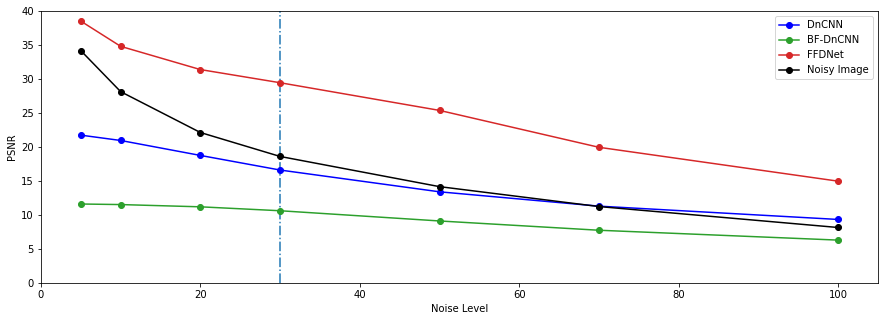

In [22]:
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(15)
n = [5,10,20,30,50,70,100]
color2 = 'tab:green'
color3 = 'tab:red'
plt.xlabel('Noise Level')
plt.ylabel('PSNR')
plt.xlim([0,105])
plt.ylim([0,40])
plt.plot(n, dncnn_psnr, marker='o', color='b')
plt.plot(n, bf_dncnn_psnr, marker='o', color=color2)
plt.plot(n, bf_ffd_psnr, marker='o', color=color3)
plt.plot(n, noisy, marker='o', color='k')
plt.stem([30],[40],'-.',markerfmt=" ")
plt.legend(['DnCNN', 'BF-DnCNN', 'FFDNet','Noisy Image'])
plt.show()

In [173]:
bf_dncnn_psnr

array([37.71      , 34.42857143, 31.20714286, 29.16714286, 26.18857143,
       23.69      , 20.85571429])